**<center><font size=6> Brain Tumor Detection </font></center>**

Author Linkedin: https://www.linkedin.com/in/edilsonsantosjr/

Dataset Reference:https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

Table of Contents: 
 - <a href='#intro'>1. Business Problem</a>
     - <a href='#tumor'>1.2 What is Brain Tumor?</a>
 - <a href='#imports'>2. Imports</a>   
     - <a href='#helperfunctions'>2.1 Helper Functions</a>
 - <a href='#loadrawimages'>3. Data Import and Preprocessing</a>
     - <a href='#cropimages'>3.1 Crop Images</a>
     - <a href='#savecropedimages'>3.2 Save Cropped Images</a>
 - <a href='#datapreparation'>4. Data Preparation</a>  
     - <a href='#rescale'>4.1 Rescale</a>
     - <a href='#splittrain-val-test'>4.2 Split Train-Val-Test</a>
 - <a href='#cnnmodel'>5. Convolutional Neural Network with VGG-16</a> 
     - <a href='#trainmodel'>5.1 Model Training</a>
     - <a href='#modelevalute'>5.2 Model Evaluation</a>
     - <a href='#testevaluation'>5.3 Evaluate on Test Data</a>
 - <a href='#businessperformace'>6. Business Performance</a> 

---
# <a id='intro'>1. Business Problem</a>

The hospital named 'HealthCare Center' conducts brain tumor diagnoses on its patients. They currently rely on manual examinations to classify tumors, which can lead to diagnostic errors and treatment delays. The hospital decides to implement a **machine learning model to classify tumors** with high accuracy.

Currently, the hospital has a diagnostic **error rate of 5%** in its brain MRI scan results.

## <a id='tumor'>1.2. What is Brain Tumor?</a>

> A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: cancerous (malignant) tumors and benign tumors. Cancerous tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors. All types of brain tumors may produce symptoms that vary depending on the part of the brain involved. These symptoms may include headaches, seizures, problems with vision, vomiting and mental changes. The headache is classically worse in the morning and goes away with vomiting. Other symptoms may include difficulty walking, speaking or with sensations. As the disease progresses, unconsciousness may occur.
>
> ![](https://upload.wikimedia.org/wikipedia/commons/5/5f/Hirnmetastase_MRT-T1_KM.jpg)
>
> *Brain metastasis in the right cerebral hemisphere from lung cancer, shown on magnetic resonance imaging.*

Source: [Wikipedia](https://en.wikipedia.org/wiki/Brain_tumor)

# <a id='imports'>2. Imports</a>

In [ ]:
import os
import numpy                              as np
import pandas                             as pd
import tensorflow                         as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers              import Flatten, Dense, Dropout
from tensorflow.keras.models              import Model
from tensorflow.keras.callbacks           import EarlyStopping
from tensorflow.keras.metrics             import Precision, Recall, BinaryAccuracy
from keras.applications.vgg16             import VGG16, preprocess_input
from PIL                                  import Image
import matplotlib.pyplot                  as plt
import seaborn                            as sns
import cv2
import imutils
from tqdm                                 import tqdm
from sklearn.model_selection              import train_test_split
from sklearn.metrics                      import confusion_matrix, recall_score, precision_score, accuracy_score, classification_report
from functools                            import partial


## <a id='helperfunctions'> 2.1 Helper Functions</a>

In [8]:
def crop_imgs(set_name, target_size=(100, 100), add_pixels_value=0):
    """
    Finds the extreme points on the image, crops the rectangular out of them,
    and resizes the cropped images to the target size.
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(new_img, target_size) 
        set_new.append(new_img)

    return np.array(set_new)

def load_data(dir_path, img_size=(100, 100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('cropped'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('cropped'):
                    img = cv2.imread(os.path.join(dir_path, path, file))
                    img = cv2.resize(img, img_size)  # Redimensionar a imagem
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()
        
def save_new_images(x_set, y_set, folder_name):
    for i, (img, imclass) in enumerate(zip(x_set, y_set)):
        if imclass == 0:
            save_path = os.path.join(folder_name, 'NO', f'{i}.jpg')
        else:
            save_path = os.path.join(folder_name, 'YES', f'{i}.jpg')
        cv2.imwrite(save_path, img)       

# <a id='loadrawimages'>3. Data Import and Preprocessing</a>

`image_dataset_from_directory` is a function provided by the Keras API in TensorFlow that allows you to create an image dataset directly from a directory structure on your file system.

In [9]:
main_path = 'C:/Users/edils/repos/brain_tumor_detection/data/normal/'

data = tf.keras.utils.image_dataset_from_directory(main_path, color_mode='grayscale')

Found 253 files belonging to 2 classes.


Our dataset contains 253 images:
 - 155 images of Tumor Brain MRI Scans
 - 98 images of Normal Brain MRI Scans

Let's look at some images

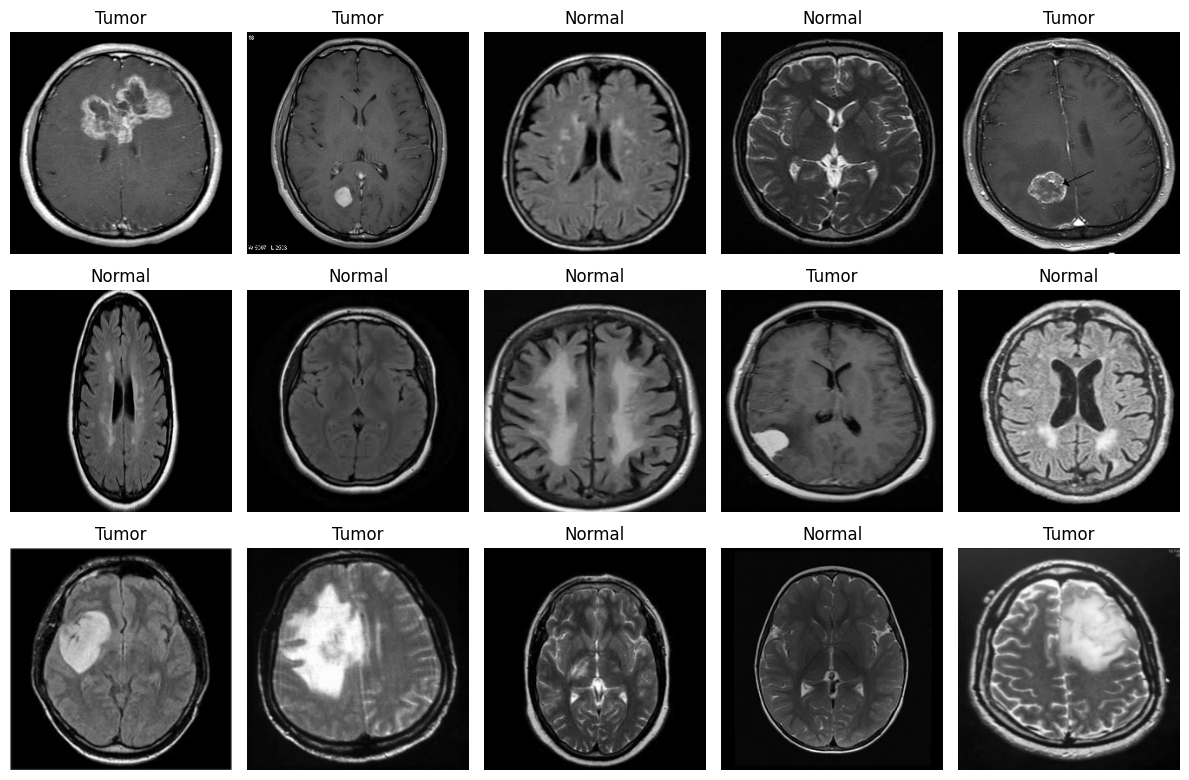

In [10]:
n_samples = 15

plt.figure(figsize=(12, 8))

i = 0

for images, labels in data.take(n_samples):
    for j in range(len(images)):  # Iterar sobre todas as imagens dentro do lote
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[j].numpy().squeeze(), cmap='gray')  # Acesse a imagem do lote
        plt.axis('off')
        if labels[j] == 1:  # Acesse o rótulo do lote
            plt.title('Tumor')
        else:
            plt.title('Normal')
    
        i += 1
        if i >= n_samples:
            break  # Parar o loop externo quando alcançar o número desejado de amostras
    if i >= n_samples:
        break  # Parar completamente quando alcançar o número desejado de amostras

plt.tight_layout()
plt.show()


## <a id='cropimages'>3.1 Crop Images</a>

---

In this section we will do some sort of normalization by removing the black corners of the image. I used the technique showed by [pyimagesearch](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog.

In [11]:
#load imagens Numpy array
X_train, y_train, labels = load_data(main_path, img_size=(256,256))

# Crop Black parts of each image
X_train_crop = crop_imgs(set_name=X_train)

100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


253 images loaded from C:/Users/edils/repos/brain_tumor_detection/data/normal/ directory.


Text(0.5, 1.0, 'Normal Image')

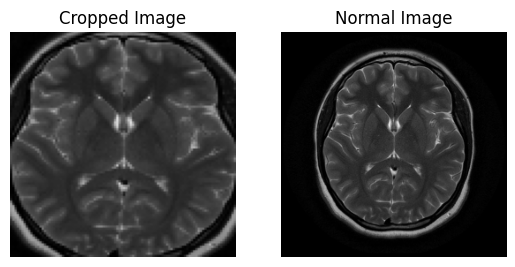

In [12]:
plt.subplot(1,2,1)
plt.imshow(X_train_crop[0])
plt.axis('off')
plt.title('Cropped Image')

plt.subplot(1,2,2)
plt.imshow(X_train[0])
plt.axis('off')
plt.title('Normal Image')



We can observe that the images are more focused on the brain, with unnecessary black corners removed.

## <a id='savecropedimages'>3.2 Save Croped Images</a>

Now let's save the Cropped Images back on my folder so we can use them for our Algorithm.

In [13]:
folder_name = 'C:/Users/edils/repos/brain_tumor_detection/data/cropped/'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

save_new_images(X_train_crop, y_train, folder_name = 'C:/Users/edils/repos/brain_tumor_detection/data/cropped/')

# <a id='datapreparation'> 4. Data Preparation </a>

Let's Load our cropped images and starting preparing them for training our model.

In [14]:
cropped_path = 'C:/Users/edils/repos/brain_tumor_detection/data/cropped/'

data_cropped = tf.keras.utils.image_dataset_from_directory(cropped_path)

Found 253 files belonging to 2 classes.


We will use a numpy_iterator to visualize data from inside data_cropped pipeline

In [15]:
data_iterator = data_cropped.as_numpy_iterator()

In [28]:
batch = data_iterator.next()
print(f'Values in Each Batch: {len(batch)}')
print(f'Shape of Each Batch {batch[0].shape}')


Values in Each Batch: 2
Shape of Each Batch (32, 256, 256, 3)


- Our batch contains 2 Values: Images and Labels
- Each one contains 32 images of 256x256 pixels

## <a id='rescale'> 4.1 Rescaling</a>

Since a image is composed by pixel going to 0 from 255 pixels, we will rescale the image from 0 to 1 by divind each element by 255

In [17]:
data_cropped = data_cropped.map(lambda x,y: (x/255, y))

## <a id='splittrain-val-test' >4.2 Split Train-Val-Test</a>

In [18]:
len(data_cropped)

8

We have 8 batches of data. I will split them into 5-2-1 Train-val-test set:

 - Train size: 5x32 = 160 images (63,25%)
 - Validation size: 2x32 = 64 images (25,25%)
 - Test size: 1x32 = 29 images(in this case the number of images will not be sufficient to complete an entire batch) (11,5%)

In [24]:
train_size = 5
val_size = 2
test_size = 1

The `take()` method is used to extract a specified number of elements from a dataset, and the `skip()` method is used to skip a specified number of elements in the dataset.

This allows us to split the batches into train, validation, and test sets without any repetition.

In [29]:
X_train = data_cropped.take(train_size)
X_val = data_cropped.skip(train_size).take(val_size)
X_test = data_cropped.skip(train_size+val_size).take(test_size)

In [30]:
train = tf.data.experimental.cardinality(X_train).numpy()
val = tf.data.experimental.cardinality(X_val).numpy()
test = tf.data.experimental.cardinality(X_test).numpy()

print(f"Batches in Training dataset: {train}")
print(f"Batches in the Validation dataset: {val}")
print(f"Batches in the Test dataset: {test}")

Batches in Training dataset: 5
Batches in the Validation dataset: 2
Batches in the Test dataset: 1


# <a id='cnnmodel'> 5.0 Convolution Neural Network with VGG-16</a>

Transfer learning is a technique in which a pre-trained model, developed for a specific task, is used as a starting point for a new, related task. Instead of training a model from scratch, transfer learning leverages the knowledge gained from one task to improve the performance on another task.

**The VGG-16 (Visual Geometry Group 16-layer)** is a popular CNN architecture used for image classification. It consists of 16 convolutional and fully connected layers and has demonstrated strong performance on a variety of image datasets.

In [31]:
#VGG 16 Import
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))

In [33]:
model=tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1)                 32769     
                                                                 
Total params: 14747457 (56.26 MB)
Trainable params: 32769 (128.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


## <a id='trainmodel'> 5.1 Model Training</a>

In [35]:
epochs=100
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6,
    restore_best_weights=True
)


history = model.fit(
    X_train,
    epochs=epochs,
    validation_data=X_val,
    callbacks=[early_stopping],
    steps_per_epoch=train_size,     
    validation_steps=val_size       
)

Epoch 1/100
5/5 [==============================] - 25s 5s/step - loss: 1.2109 - accuracy: 0.5375 - val_loss: 1.1228 - val_accuracy: 0.6719
Epoch 2/100
5/5 [==============================] - 25s 5s/step - loss: 0.8012 - accuracy: 0.6313 - val_loss: 0.8551 - val_accuracy: 0.5781
Epoch 3/100
5/5 [==============================] - 26s 6s/step - loss: 0.5838 - accuracy: 0.7063 - val_loss: 0.5965 - val_accuracy: 0.7656
Epoch 4/100
5/5 [==============================] - 28s 6s/step - loss: 0.4654 - accuracy: 0.7875 - val_loss: 0.3293 - val_accuracy: 0.8594
Epoch 5/100
5/5 [==============================] - 28s 6s/step - loss: 0.3328 - accuracy: 0.9000 - val_loss: 0.2509 - val_accuracy: 0.9062
Epoch 6/100
5/5 [==============================] - 28s 6s/step - loss: 0.2767 - accuracy: 0.8750 - val_loss: 0.2594 - val_accuracy: 0.9062
Epoch 7/100
5/5 [==============================] - 28s 6s/step - loss: 0.2472 - accuracy: 0.9312 - val_loss: 0.2527 - val_accuracy: 0.9375
Epoch 8/100
5/5 [==========

## <a id='modelevalute'> 5.2 Model Evaluation</a>

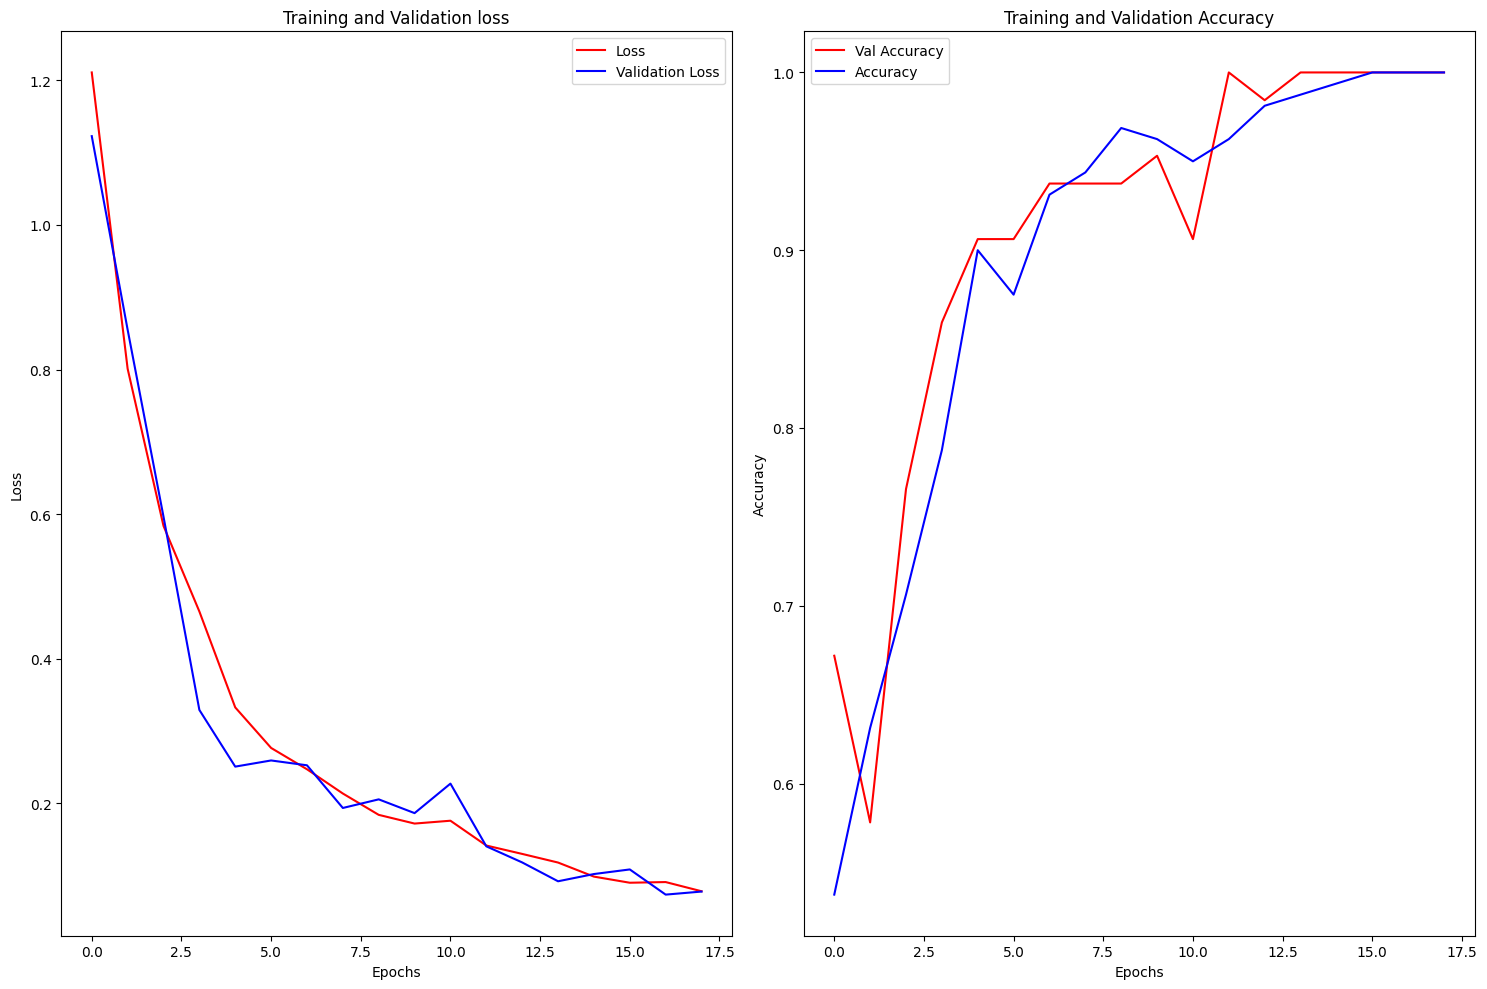

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
acc = history.history['accuracy']

epochs = [*range(len(history.epoch))]

plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc, 'r')
plt.plot(epochs, acc, 'b')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Val Accuracy", "Accuracy"])

plt.tight_layout()
plt.show()


The VGG-16 has stabilized at **100% accuracy** for both training and validation. Let's examine the confusion matrix for the validation batches:

1/1 [==============================] - 3s 3s/step
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


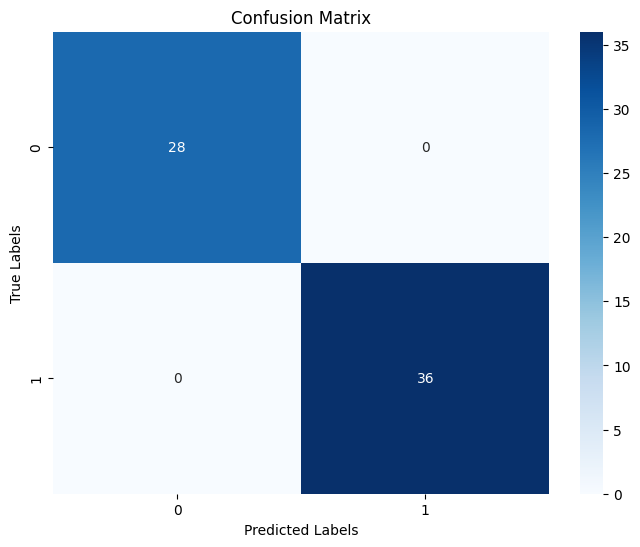

In [37]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

all_true_labels = []
all_predicted_labels = []

for batch in X_val.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)
    
    y_pred_class = (y_pred >= 0.5).astype(int)
    all_true_labels.extend(y)
    all_predicted_labels.extend(y_pred_class)

conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

print(f'Precision: {precision.result().numpy()}')
print(f'Recall: {recall.result().numpy()}')
print(f'Accuracy: {accuracy.result().numpy()}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

The model was able to label correctly 36 of the 36 Tumor MRI brain scans and 28 of the 28 Normal MRI brain scans.

## <a id='testevaluation'> 5.3 Evaluate on Test Data</a>

Now let's see if our model was able to **generalize for new data**, below is our confusion matrix for the 29 images in the Test Dataset:

1/1 [==============================] - 3s 3s/step
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


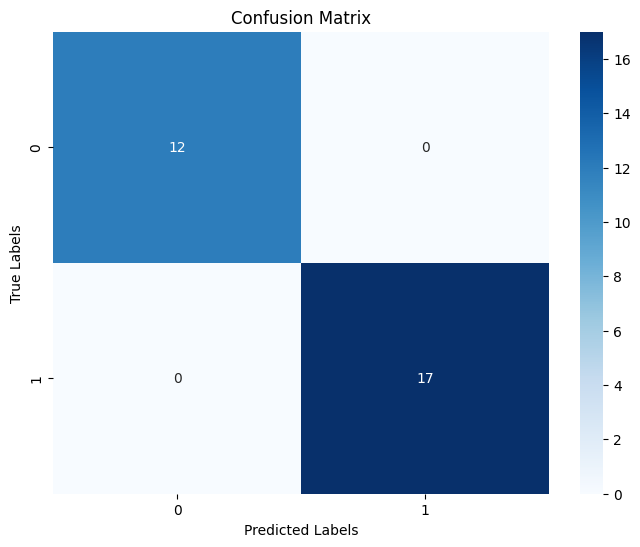

In [38]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

all_true_labels = []
all_predicted_labels = []

for batch in X_test.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)
    
    y_pred_class = (y_pred >= 0.5).astype(int)
    all_true_labels.extend(y)
    all_predicted_labels.extend(y_pred_class)

conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

print(f'Precision: {precision.result().numpy()}')
print(f'Recall: {recall.result().numpy()}')
print(f'Accuracy: {accuracy.result().numpy()}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Amazing! Our model was able to label correctly all 29 new images of the Test Dataset. I think it's ready for production!

In [39]:
#Saving model for production
model.save('final_model_VGG-16')

INFO:tensorflow:Assets written to: final_model_VGG-16\assets


INFO:tensorflow:Assets written to: final_model_VGG-16\assets


# <a id='businessperformace'> 6.0 Business Performance</a>

---

### Ok, but how can our model deliver value to the business? 

First, let's look on how the **tradicional diagnosis** for brain tumors works:

 - 1. **Initial Medical Consultation:** The patient visits a doctor who evaluates their symptoms and medical history. This usually takes about 30 minutes.
 - 2. **Referral for Diagnostic Tests:** Based on the consultation, the doctor may recommend diagnostic tests such as MRI and cerebral angiography. Scheduling and conducting these tests might take several days.
 - 3. **Completion of Diagnostic Tests**: The patient undergoes the recommended tests, which can last around 1 to 2 hours each.

 - 4. **Radiological Analysis:** Specialized radiologists analyze the test results and produce reports for the medical team. This process might take 1 to 3 days, depending on workload.

 - 5. **Medical Discussion and Diagnosis:** Medical professionals review the reports and hold discussions to arrive at a diagnosis. This step can take additional days.

 - 6. **Confirmation through Biopsy (If Needed):** If the diagnosis remains uncertain, a biopsy might be recommended, which requires additional scheduling and procedure time, typically spanning a few weeks.

 - 7. **Final Diagnosis and Treatment Planning:** The medical team consolidates information, makes a final diagnosis, and discusses treatment options with the patient. This could span from several more days to weeks.

**Total Time:** The traditional diagnosis process can take anywhere from a **few weeks to over a month**, influenced by the case complexity and logistical factors.


 - Looking at our model, we could greatly decrease the 4th and 5th steps from the tradicional diagnosis, **reducing the diagnosis from several weeks to several hours to a day**.
---
    
Second, What is the error rate for MRI Scans?  
    
According to [this article](https://pubs.rsna.org/doi/abs/10.1148/rg.2018180021?journalCode=radiographics) from RadioGraphics, the average diagostic error rate ranges from **3% to 5%** involving imaging.
    
Assuming that the error rate for HealthCare Center is 5% and the hospital serves an average of 200 patients per month for brain tumor examinations and each patient generates an average revenue of \\$5,000 our financial impacts for HealthCare Center will be:

Lost Revenue due to incorrect diagnoses(5\% of 200 patients) = 10 patients x \\$5,000 = \\$50,000.

If our model corrects these inaccurate diagnoses for the hospital, the **revenue would increase by \\$50,000 per month or  \\$600,000 per year**.
    
    